In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams.update({
    "text.usetex": True})

import astropy.units as u
from astropy.table import Table
from astropy.time import Time
from scipy.optimize import fsolve
import emcee
import corner

In [43]:
raw = np.loadtxt('hii_625.txt')
t = raw[:, 0]
epoch0 = t[0]
RA_h = raw[0, 1]
RA_m = raw[0, 2]
RA_s = raw[:, 3]
RAerr = raw[:, 4] / 12 * 180 * 1000  #mas
Dec_deg = raw[0, 5]
Dec_m = raw[0, 6]
Dec_s = raw[:, 7]
Decerr = raw[:, 8] * 1000  #mas
RAo = (RA_h + RA_m / 60 + RA_s / 3600) / 12 * np.pi  # radian
Deco = (Dec_deg + Dec_m / 60 + Dec_s / 3600) / 180 * np.pi  # radian
RA = RAo[0]
Dec = Deco[0]

In [44]:
RAerr, Decerr

(array([0.063 , 0.108 , 0.0375, 0.0135, 0.06  , 0.1395, 0.0885, 0.1215]),
 array([0.179, 0.143, 0.068, 0.027, 0.077, 0.249, 0.099, 0.182]))

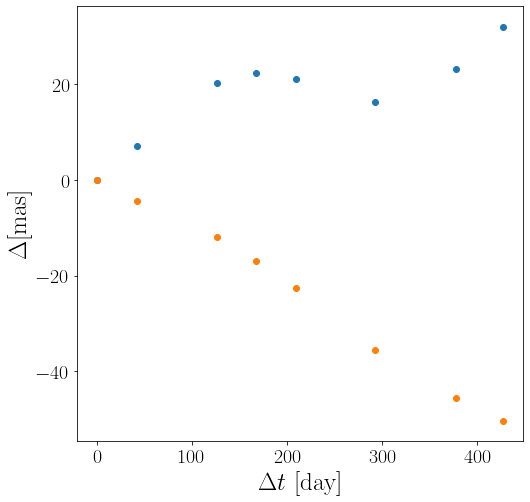

In [45]:
plt.figure(figsize=(8, 8))
plt.errorbar(t - epoch0, (RAo - RA) * 180 / np.pi * 3600 * 1000,
             yerr=RAerr,
             fmt='o')
plt.errorbar(t - epoch0, (Deco - Dec) * 180 / np.pi * 3600 * 1000,
             yerr=Decerr,
             fmt='o')
plt.xlabel(r'$\Delta t\ \mathrm{[day]}$', fontsize=25)
plt.ylabel(r'$\Delta \mathrm{[mas]}$', fontsize=25)
plt.show()

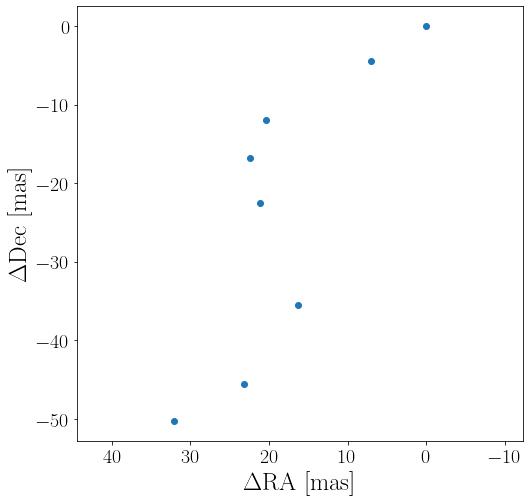

In [27]:
plt.figure(figsize=(8, 8))
plt.scatter((RAo - RAo[0]) * 180 / np.pi * 3600 * 1000,
            (Deco - Deco[0]) * 180 / np.pi * 3600 * 1000)
plt.axis('equal')
plt.xlabel(r'$\Delta \mathrm{RA\ [mas]}$', fontsize=25)
plt.ylabel(r'$\Delta \mathrm{Dec\ [mas]}$', fontsize=25)
plt.gca().invert_xaxis()
plt.show()

## Parallax

In [9]:
# Julian Date of Vernal Equinox at 2000: 2451623.815972
# Julian Date of Perihelion at 2000 : 2451546.708333
# Earth Orbital Period : 365.25 days
# Earth Obliquity : 23.44 deg
# Orbit eccentricity : 0.0167
# date = JD

TE = 2451623.815972
TPeri = 2451546.708333
P = (1 * u.year).to(u.day).value
E = 23.44 * u.degree
e = 0.0167


def psi_t(t, T0=0):
    theta = ((t - T0) / P - np.floor((t - T0) / P)) * np.pi * 2

    def Psi(psi):
        return psi - e * np.sin(psi) - theta

    return fsolve(Psi, [theta])


def Earth_to_Sun(HJD):
    # Eccentric anomaly of the Vernal Equinox at 2000
    xE = (np.cos(psi_t(TE, T0=TPeri)) - e)
    yE = (np.sqrt(1 - e**2) * np.sin(psi_t(TE, T0=TPeri)))
    Delta = np.arctan2(yE, xE)
    X = (np.cos(psi_t(HJD, T0=TPeri)) - e)
    Y = (np.sqrt(1 - e**2) * np.sin(psi_t(HJD, T0=TPeri)))
    XE = (X * np.cos(Delta) + Y * np.sin(Delta))
    YE = (-X * np.sin(Delta) + Y * np.cos(Delta)) * np.cos(E)
    ZE = (-X * np.sin(Delta) + Y * np.cos(Delta)) * np.sin(E)
    return (XE, YE, ZE)


def S(T, Tp=epoch0):
    EtS = np.array(Earth_to_Sun(T))
    vec = np.array(
        [np.cos(Dec) * np.cos(RA),
         np.cos(Dec) * np.sin(RA),
         np.sin(Dec)])
    vecN = np.array([0, 0, 1])
    vecE = np.cross(vecN, vec)
    vecN = np.cross(vec, vecE)
    vecN = vecN / np.sqrt(np.dot(vecN, vecN))
    vecE = vecE / np.sqrt(np.dot(vecE, vecE))
    projN = [np.dot(EtS[:, i], vecN) for i in range(len(EtS[0, :]))]
    projE = [np.dot(EtS[:, i], vecE) for i in range(len(EtS[0, :]))]

    return (np.array([projN, projE / np.cos(Dec)]))

### MCMC for Gaia parallax fitting

In [57]:
def log_prior(theta):
    dRA, dDec, mu_ra, mu_de, plx = theta
    if 16 < mu_ra < 26 and -49 < mu_de < -39 and 2 < plx < 12:
        if abs(dRA) < 10 and abs(dDec) < 10:
            return 0.0
    return -np.inf


def log_likelihood(theta, x, y, sigma):
    dRA, dDec, mu_ra, mu_de, plx = theta
    T = x
    X0, Y0 = y
    err1, err2 = sigma
    epoch0 = T[0]
    X = dRA + mu_ra * (T - epoch0) / P + S(T)[1] * plx
    Y = dDec + mu_de * (T - epoch0) / P + S(T)[0] * plx
    return -0.5 * (((X - X0)**2 / err1**2 + (Y - Y0)**2 / err2**2).sum())


def log_probability(theta, x, y, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sigma)

In [58]:
nwalkers = 32
ndim = 5
p0 = np.random.rand(nwalkers, ndim) - 0.5
p0[:, 2] += 21
p0[:, 3] += -44
p0[:, 4] += 7

sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_probability,
    args=(t, ((RAo - RA) * 180 / np.pi * 3600 * 1000,
                       (Deco - Dec) * 180 / np.pi * 3600 * 1000), (RAerr,
                                                                   Decerr)))
sampler.run_mcmc(p0, 2000, progress=True);

100%|██████████| 2000/2000 [01:45<00:00, 19.03it/s]


Text(0.5, 0, 'step number')

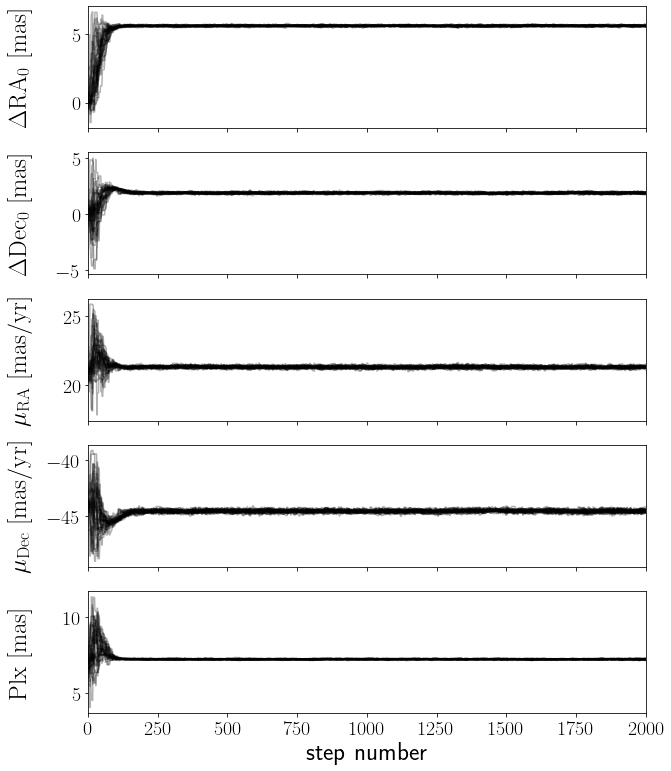

In [59]:
fig, axes = plt.subplots(5, figsize=(10, 13), sharex=True)
samples = sampler.get_chain()
labels = [
    r"$\Delta\mathrm{RA}_0\ \mathrm{[mas]}$",
    r"$\Delta\mathrm{Dec}_0\ \mathrm{[mas]}$",
    r"$\mu_\mathrm{RA}\ \mathrm{[mas/yr]}$",
    r"$\mu_\mathrm{Dec}\ \mathrm{[mas/yr]}$", r"$\mathrm{Plx}\ \mathrm{[mas]}$"
]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize=25)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number", fontsize=25)
#axes[2].set_ylim(-2.9, -2.6)
#axes[3].set_ylim(3.65, 3.9)
#axes[4].set_ylim(0.67, 0.74)

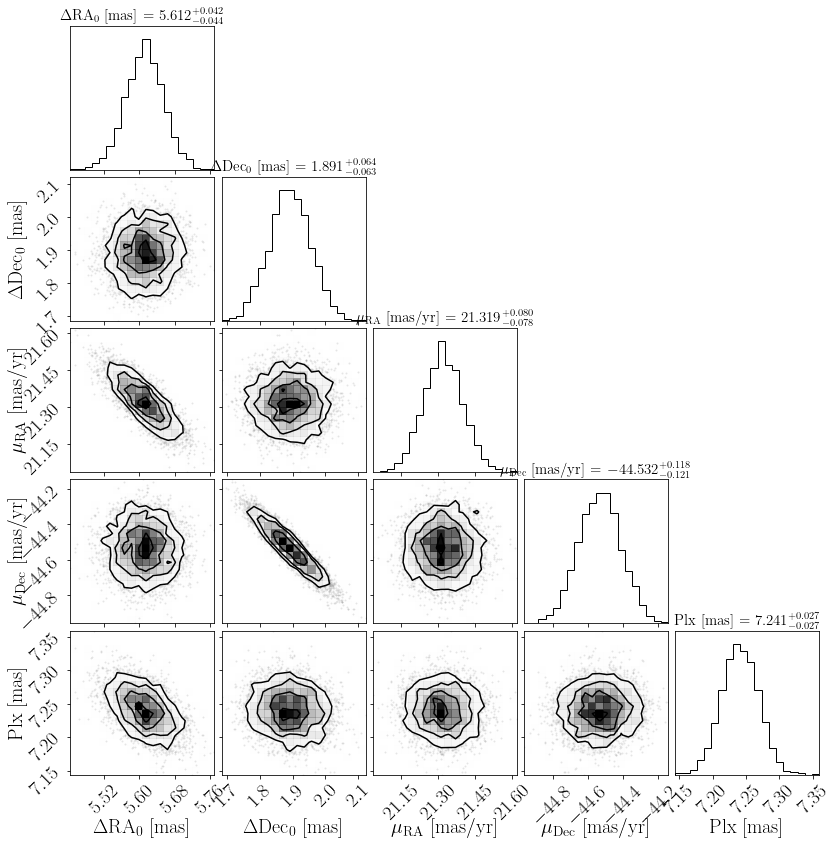

In [68]:
fig = corner.corner(
    sampler.get_chain(discard=200, thin=15, flat=True),
    labels=labels,
    show_titles=True,
    label_kwargs={"fontsize": 20},
    title_kwargs={"fontsize": 15},
    title_fmt='.3f',
)

In [65]:
dRA, dDec, mu_ra, mu_de, plx = 5.612, 1.891, 21.316, -44.532, 7.241

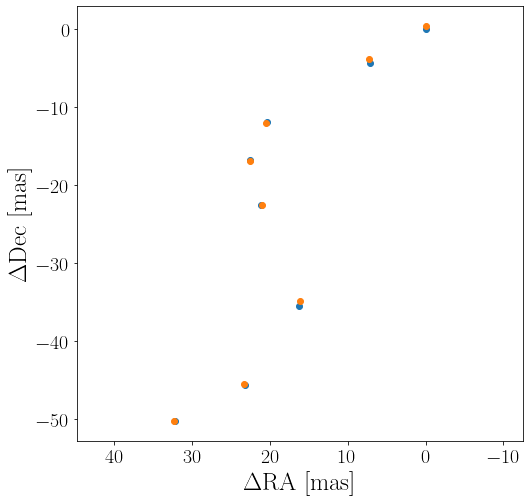

In [66]:
plt.figure(figsize=(8, 8))
plt.scatter((RAo - RAo[0]) * 180 / np.pi * 3600 * 1000,
            (Deco - Deco[0]) * 180 / np.pi * 3600 * 1000)
X = dRA + mu_ra * (t - epoch0) / P + S(t)[1] * plx
Y = dDec + mu_de * (t - epoch0) / P + S(t)[0] * plx
plt.scatter(X, Y)
plt.axis('equal')
plt.xlabel(r'$\Delta \mathrm{RA\ [mas]}$', fontsize=25)
plt.ylabel(r'$\Delta \mathrm{Dec\ [mas]}$', fontsize=25)
plt.gca().invert_xaxis()
plt.show()

In [67]:
D = 1000/7.241
D

138.10247203424942